Image Denoising using: 

In [5]:
from sklearn import metrics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from tensorflow.keras.datasets import mnist
from numpy.fft import fft2, ifft2
from scipy.signal import gaussian, convolve2d
from scipy import ndimage, misc
import matplotlib.pyplot as plt
import matplotlib.image as img
import skimage
from skimage.restoration import denoise_tv_chambolle, denoise_bilateral, denoise_nl_means, estimate_sigma
from skimage import data, img_as_float
from skimage import measure
from skimage import util 
from copy import deepcopy
import random

In [6]:
 # We do not require the ground truth labelled data, hence not loading the y labels neither fro training nor for testing
    
(x_train,_), (x_test,_) = mnist.load_data()

print(x_train.shape)
print(x_test.shape)

11493376/11490434 [==============================] - 3s 0us/step
(60000, 28, 28)
(10000, 28, 28)


In [7]:
x_mnist_5 = x_train[1:6]
x_mnist_5.shape

(5, 28, 28)

In [9]:
# Image Plotting function
def plot_func(images, saveimage, x=1,y=6, cmap='gray', savename=''):
    plt.figure(figsize=(20,3))
    for i in range(len(images)):
        ax = plt.subplot(x,y,i+1)
        plt.imshow(images[i], cmap = 'gray')
        
    if(saveimage==True):
        plt.savefig(savename, bbox_inches='tight', format = 'png')

# Creating database

# a) Natural Image set (512x512)

The shape of loaded image database is  (5, 512, 512)


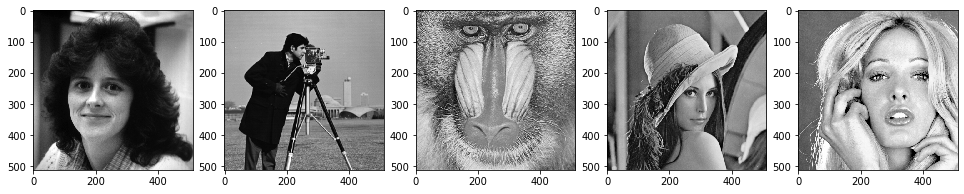

In [10]:
# Creating database of test images

imagenames = ["woman_darkhair.tif","cameraman.tif", "mandril_gray.tif", "lena_gray_512.tif", "woman_blonde.tif" ]
images = []

for i in range(len(imagenames)):
    images.append(img.imread('standard_test_images/' + imagenames[i]))
images = np.array(images)

# Plot images
plot_func(images, saveimage=True, savename='Original_Natural_Images.png',x=1,y=6)

print("The shape of loaded image database is ",images.shape)

# b) MNIST Image set (28x28)

The shape of loaded image database is  (5, 28, 28)


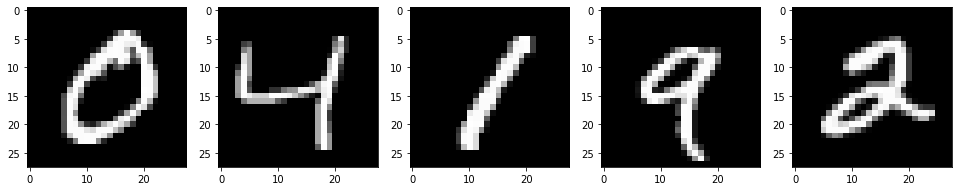

In [11]:
# Creating database of test images from MNIST

x_mnist_inv = []

for i in range(len(x_mnist_5)):
    x_mnist_inv.append(x_mnist_5[i])
x_mnist_inv = np.array(x_mnist_inv)

# Plot images
plot_func(x_mnist_inv, saveimage=True, savename='Inverted_MNIST_images.png',x=1,y=6)

print("The shape of loaded image database is ",x_mnist_inv.shape)

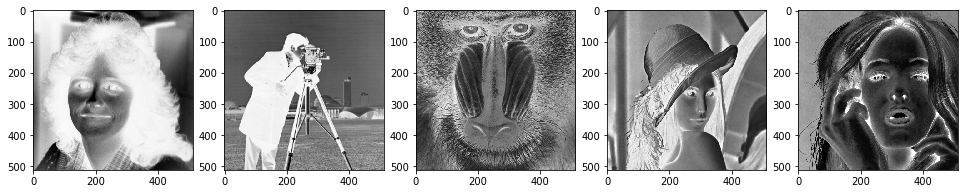

In [12]:
# Inverting the Natural test Images 

images_inv = util.invert(images)

# Printing and saving inverted images
plot_func(images_inv, saveimage=True, savename='Inverted_Natural_images.png', x=1,y=6)

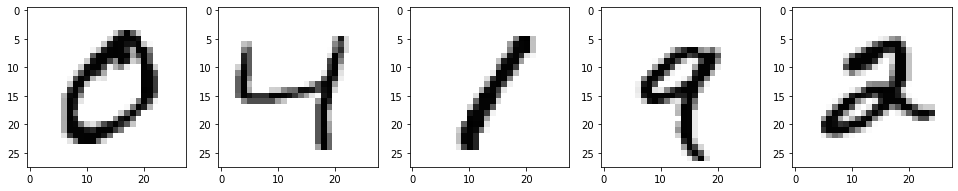

In [13]:
# Inverted the MNIST test images

x_mnist = util.invert(x_mnist_inv)

# Printing and saving inverted images
plot_func(x_mnist, saveimage=True, savename='Original_MNIST_images.png', x=1,y=6)

# DIFFERENT NOISE TYPES

# a) Gaussian Noise

In [14]:
def gaussian_noise(image,mean,variance):
    g_noise = image +  0.5 * np.random.normal(loc=mean, scale=variance, size = image.shape)
    return g_noise

# b) Poisson Noise

In [15]:
def poisson(image):
    p_noise = np.random.poisson(image)
    return p_noise

# c) Salt and Pepper Noise

In [16]:
# Creating function for salt and paper noise

def sp_noise(x_img,prob):
    x_noise = np.zeros(x_img.shape,np.uint8)
    thres = 1 - prob 
    for i in range(x_img.shape[0]):
        for j in range(x_img.shape[1]):
            rdn = random.random()
            if rdn < prob:
                x_noise[i][j] = 0
            elif rdn > thres:
                x_noise[i][j] = 255
            else:
                x_noise[i][j] = x_img[i][j]
    return x_noise

# FILTERS

## a) Weiner Filter

In [17]:
def wiener_filter(img, kernel, K):
    kernel /= np.sum(kernel)
    dummy = np.copy(img)
    dummy = fft2(dummy, axes = (-2, -1))
    kernel = fft2(kernel, s = img.shape)
    kernel = np.conj(kernel) / (np.abs(kernel) ** 2 + K)
    dummy = dummy * kernel
    dummy = np.abs(ifft2(dummy))
    return dummy

def gaussian_kernel(kernel_size = 3):
    h = gaussian(kernel_size, kernel_size / 3).reshape(kernel_size, 1)
    h = np.dot(h, h.transpose())
    h /= np.sum(h)
    return h

## b) Bilateral Filter 

In [18]:
def bilateral_filter(images_noisy, sigma_spat=1):
    x_filt_bilG = np.zeros(images_noisy.shape)

    for i in range (len(images)):  
        x_filt_bilG[i] = denoise_bilateral(images_noisy[i],  sigma_spatial = sigma_spat)
    return x_filt_bilG

# Creating Images with Noise


## a) Gaussian Noise 

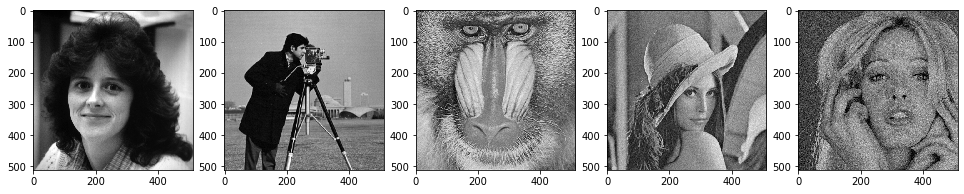

In [19]:
# Creating noisy images by adding Gaussian noise with variance 5, 10, 20 and 50 to clean Natural images

images_noisy_G = []

var = [0, 5, 10, 20, 50] 
#var = [0, 0.05, 0.1, 0.15, 0.2]
for i in range(len(images)):
    images_noisy_G.append(np.abs(gaussian_noise(images[i], mean=0.0, variance=var[i])))
images_noisy_G = np.array(images_noisy_G)    


plot_func(images_noisy_G, saveimage=True, savename='Natural_Image_Gaussian_Noise.png',x=1,y=6)

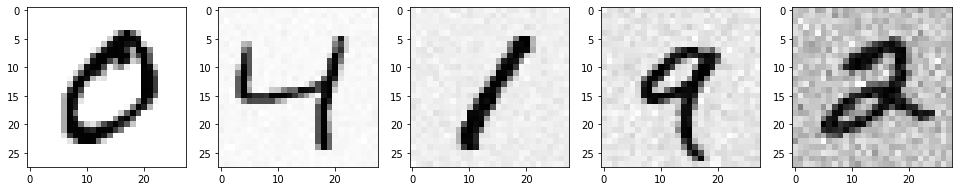

In [21]:
# Creating noisy images by adding Gaussian noise with variance 5, 10, 20 and 50 to clean MNIST images

mnist_noisy_G = []

var = [0, 5, 10, 20, 50] 
#var = [0, 0.05, 0.1, 0.15, 0.2]
for i in range(len(x_mnist)):
    mnist_noisy_G.append(np.abs(gaussian_noise(x_mnist[i], mean=0.0, variance=var[i])))
mnist_noisy_G = np.array(mnist_noisy_G)    

plot_func(mnist_noisy_G, saveimage=True, savename='MNIST_Image_Gaussian_Noise.png',x=1,y=6)

##  b) Poisson Noise

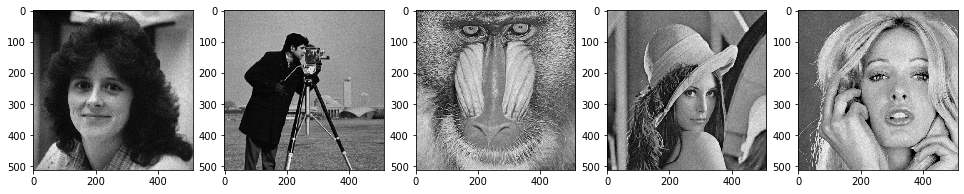

In [22]:
# Adding Poisson noise to the clean Natural images

noise_mask = np.zeros(images.shape)
images_noise_P = np.zeros(images.shape)


for i in range (len(images)):
    noise_mask = poisson(images[i])
    images_noise_P[i] = images[i] + noise_mask
plot_func(images_noise_P, saveimage=True, savename='Natural_Image_Poison_Noise.png', x=1, y=6)


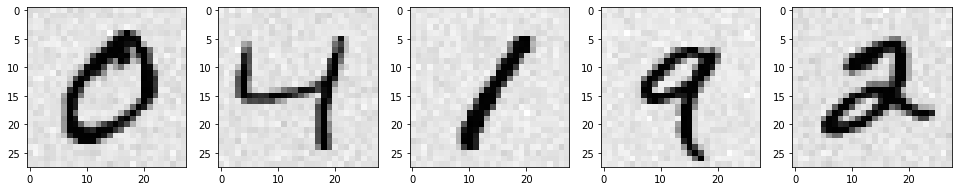

In [23]:
# Adding Poisson noise to the clean MNIST images

noise_mask = np.zeros(x_mnist.shape)
mnist_noise_P = np.zeros(x_mnist.shape)


for i in range (len(x_mnist)):
    noise_mask = poisson(x_mnist[i])
    mnist_noise_P[i] = x_mnist[i] + noise_mask
plot_func(mnist_noise_P, saveimage=True, savename='MNIST_Image_Poisson_Noise.png', x=1, y=6)

## c) Salt and Pepper Noise 

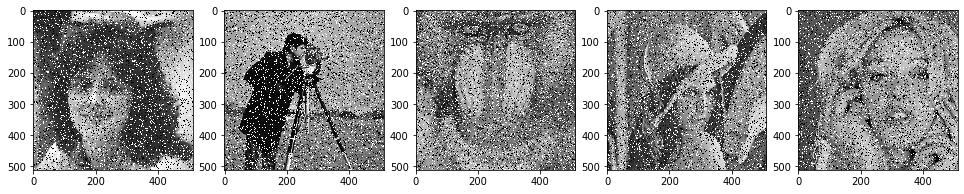

In [24]:
# Adding Salt and Pepper noise to clean Natural images

images_noise_SnP = np.zeros(images.shape)

for i in range (len(images)):
    images_noise_SnP[i] = sp_noise(images[i],0.1)

plot_func(images_noise_SnP, saveimage=True, savename='Natural_Image_Salt&Pepper_Noise.png',x=1 , y=6)

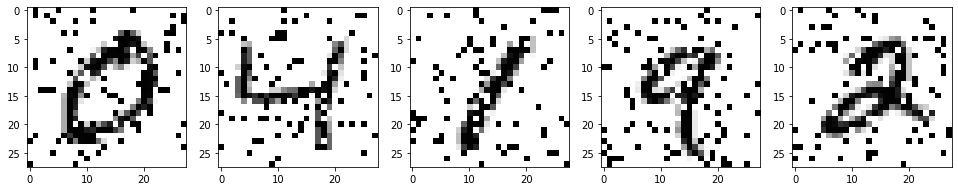

In [25]:
# Adding Salt and Pepper noise to MNIST clean images

mnist_noise_SnP = np.zeros(x_mnist.shape)

for i in range (len(x_mnist)):
    mnist_noise_SnP[i] = sp_noise(x_mnist[i],0.1)

plot_func(mnist_noise_SnP, saveimage=True, savename='MNIST_Image_Salt&Pepper_Noise.png',x=1 , y=6)

# WEINER FILTER

Here we'll be using a type of Spatial Linear Filtering Techniques: Weiner Filter

## a) Filtering Gaussian Noise

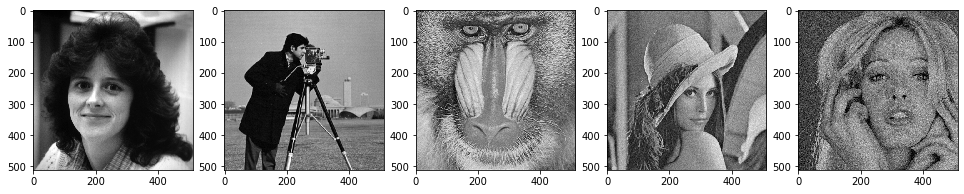

In [26]:
# Plotting images with Gaussian Noise with varying variance [0, 5, 10, 20, 50]
plot_func(images_noisy_G, saveimage=False,x=1,y=6)

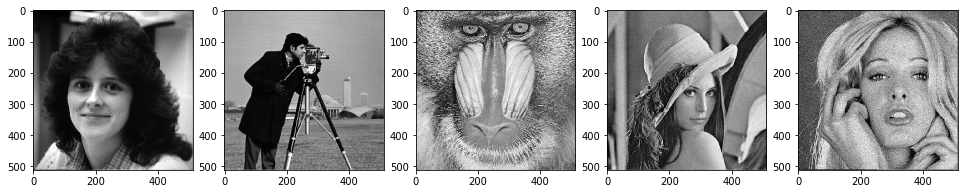

In [27]:
# Filtering Gaussian noise on Natural Images using Weiner filter

images_filt_weinG = np.zeros(images_noisy_G.shape)
kernel = gaussian_kernel(3)

for i in range (len(images)):
    images_filt_weinG[i] = wiener_filter(images_noisy_G[i], kernel, K = 20)

plot_func(images_filt_weinG, saveimage=True, savename='WeinerFilter_Natural_Gaussian.png',x=1,y=6)

In [28]:
# Evaluating Weiner Filter Performance on Natural Images corrupted by GAUSSIAN NOISE

# Show SSIM and PSNR evaluation of noisy images with actual images

print('Performance of Weiner Filter on Natural image corrupted by Gaussian Noise-->')
ssim_weinG = 0
ssim_weinG_list = []
psnr_weinG_list = []
for i in range (len(images)):
    ssim_weinG = measure.compare_ssim(images_filt_weinG[i], images[i])#ssim_weinG = measure.compare_ssim(images_noisy_G[i], images[i])
    ssim_weinG_list.append(ssim_weinG)
   
    psnr_weinG = measure.compare_psnr(images[i], images_filt_weinG[i]) 
    psnr_weinG_list.append(psnr_weinG)
    
    print('For image ',i)
    print('SSIM: ',ssim_weinG)
    print('PSNR', psnr_weinG)
avg_ssim = np.sum(ssim_weinG_list)/len(ssim_weinG_list)
print('Average SSIM', avg_ssim)
avg_psnr = np.sum(psnr_weinG_list)/len(ssim_weinG_list)
print('Average SSIM', avg_psnr)

Performance of Weiner Filter on Natural image corrupted by Gaussian Noise-->
For image  0
SSIM:  0.00574661265918889
PSNR 6.669570608981399


C:\Users\sahil\anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\sahil\anaconda3\lib\site-packages\skimage\measure\_structural_similarity.py:17: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  **kwargs)
C:\Users\sahil\anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
  del sys.path[0]
C:\Users\sahil\anaconda3\lib\site-packages\skimage\measure\simple_metrics.py:65: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  return peak_signal_noise_ratio(im_true, im_test, data_range=data_range)


For image  1
SSIM:  0.005067079141109802
PSNR 6.036801298866812
For image  2
SSIM:  0.0044347734134764305
PSNR 5.9711753583746745
For image  3
SSIM:  0.004569598207112488
PSNR 6.077219630452584
For image  4
SSIM:  0.003967309026970325
PSNR 5.531114113164561
Average SSIM 0.004757074489571586
Average SSIM 6.057176201968007


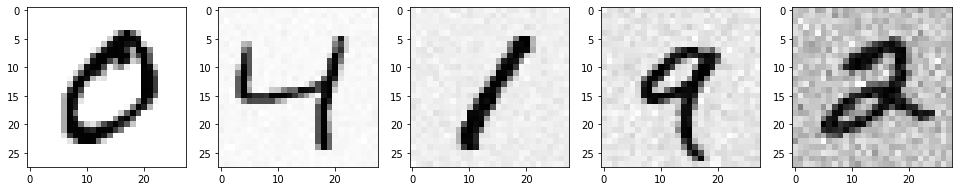

In [29]:
# Plotting images with Gaussian Noise with varying variance [0, 5, 10, 20, 50]
plot_func(mnist_noisy_G, saveimage=False,x=1,y=6)

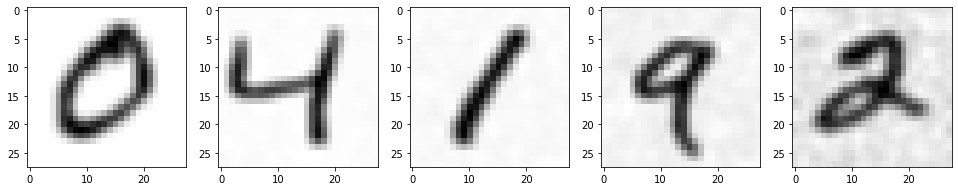

In [30]:
# Filtering Gaussian noise on MNIST Images using Weiner filter

mnist_filt_weinG = np.zeros(mnist_noisy_G.shape)
kernel = gaussian_kernel(3)

for i in range (len(images)):
    mnist_filt_weinG[i] = wiener_filter(mnist_noisy_G[i], kernel, K = 20)

plot_func(mnist_filt_weinG, saveimage=True, savename='WeinerFilter_MNIST_Gaussian.png',x=1,y=6)

In [31]:
# Evaluating Weiner Filter Performance on MNIST Images corrupted by GAUSSIAN NOISE

# Show SSIM and PSNR evaluation of noisy images with actual images

print('Performance of Weiner Filter on MNIST Images corrupted by Gaussian Noise-->')
ssim_weinG_mnist = 0
ssim_weinG_mnist_list = []
psnr_weinG_mnist_list = []
for i in range (len(images)):
    ssim_weinG_mnist = measure.compare_ssim(mnist_filt_weinG[i], x_mnist[i])#ssim_weinG = measure.compare_ssim(images_noisy_G[i], images[i])
    ssim_weinG_mnist_list.append(ssim_weinG_mnist)
   
    psnr_weinG_mnist = measure.compare_psnr(images[i], images_filt_weinG[i]) 
    psnr_weinG_mnist_list.append(psnr_weinG_mnist)
    
    print('For image ',i)
    print('SSIM: ',ssim_weinG_mnist)
    print('PSNR', psnr_weinG_mnist)
    

Performance of Weiner Filter on MNIST Images corrupted by Gaussian Noise-->
For image  0
SSIM:  0.009129678028466391
PSNR 6.669570608981399
For image  1
SSIM:  0.014778020447296876
PSNR 6.036801298866812
For image  2
SSIM:  0.0136272468088689
PSNR 5.9711753583746745
For image  3
SSIM:  0.006384323535302207
PSNR 6.077219630452584
For image  4
SSIM:  0.00430862095987409
PSNR 5.531114113164561


C:\Users\sahil\anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\sahil\anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
  del sys.path[0]


## b) Filtering Poisson Noise

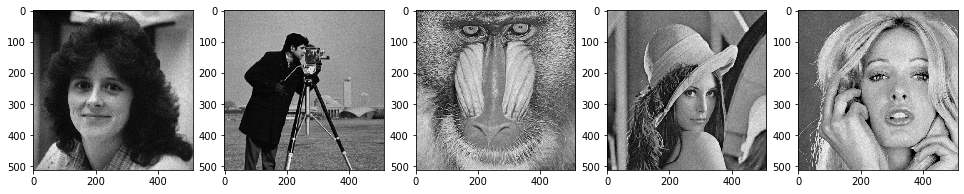

In [32]:
# Plotting images with Poisson Noise
plot_func(images_noise_P, saveimage=False, x=1, y=6)

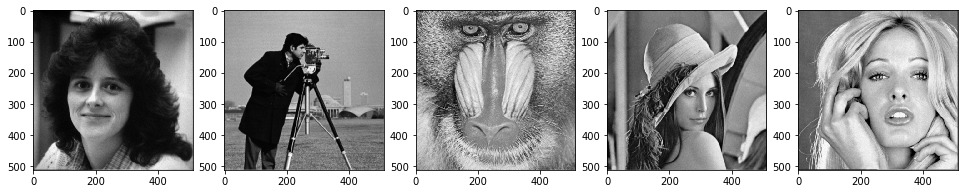

In [33]:
# Filtering Poisson noise images using Weiner Filter on NATURAL images

images_filt_weinP = np.zeros(images_noise_P.shape)
kernel = gaussian_kernel(3)

for i in range (len(images_noise_P)):
    images_filt_weinP[i] = wiener_filter(images_noise_P[i], kernel, K = 20)

plot_func(images_filt_weinP, saveimage=True, savename='WeinerFilter_Natural_Poisson.png',x=1, y=6)

In [34]:
# Evaluating performance
print('Performance of Weiner Filter on Natural Images corrupted by Poisson Noise-->')
ssim_weinP = 0
ssim_weinP_list=[]
psnr_weinP_list=[]

for i in range (len(images)):
    ssim_weinP = measure.compare_ssim(images_filt_weinP[i], images[i])
    ssim_weinP_list.append(ssim_weinP)
    #ssim_wein +=ssim_wein
    #avg = ssim_wein/(len(x_img_5))   
    psnr_weinP = measure.compare_psnr(images[i], images_filt_weinP[i]) 
    psnr_weinP_list.append(psnr_weinP)
    print('For', i, 'image')
    print('SSIM: ',ssim_weinP)
    print('PSNR: ',psnr_weinP)

avg_ssim = np.sum(ssim_weinP_list)/len(ssim_weinP_list)
print('Average SSIM', avg_ssim)
avg_psnr = np.sum(psnr_weinP_list)/len(ssim_weinP_list)
print('Average PSNR', avg_psnr)

Performance of Weiner Filter on Natural Images corrupted by Poisson Noise-->
For 0 image
SSIM:  0.022351828308075288
PSNR:  7.113726132913251


C:\Users\sahil\anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  
C:\Users\sahil\anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
  if sys.path[0] == '':


For 1 image
SSIM:  0.019540194587945724
PSNR:  6.478300624978088
For 2 image
SSIM:  0.01754053452607841
PSNR:  6.409147814630235
For 3 image
SSIM:  0.01796713205179049
PSNR:  6.519417972460313
For 4 image
SSIM:  0.015661544797054942
PSNR:  5.972210128851448
Average SSIM 0.01861224685418897
Average PSNR 6.498560534766668


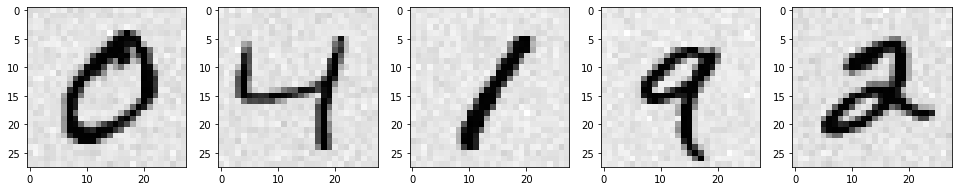

In [35]:
# Plotting images with Poisson Noise
plot_func(mnist_noise_P, saveimage=False, x=1, y=6)

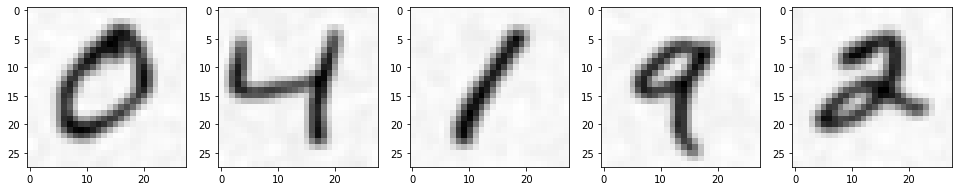

In [36]:
# Filtering Poisson noise images using Weiner Filter on MNIST images

mnist_filt_weinP = np.zeros(mnist_noise_P.shape)
kernel = gaussian_kernel(3)

for i in range (len(mnist_noise_P)):
    mnist_filt_weinP[i] = wiener_filter(mnist_noise_P[i], kernel, K = 20)

plot_func(mnist_filt_weinP, saveimage=True, savename='WeinerFilter_MNIST_Poisson.png',x=1, y=6)

In [37]:
# Evaluating performance
print('Performance of Weiner Filter on MNIST Images corrupted by Poisson Noise-->')
ssim_weinP_mnist = 0
ssim_weinP_mnist_list=[]
psnr_weinP_mnist_list=[]

for i in range (len(x_mnist)):
    ssim_weinP_mnist = measure.compare_ssim(mnist_filt_weinP[i], x_mnist[i])
    ssim_weinP_mnist_list.append(ssim_weinP_mnist)
    #ssim_wein +=ssim_wein
    #avg = ssim_wein/(len(x_img_5))   
    psnr_weinP_mnist = measure.compare_psnr(x_mnist[i], mnist_filt_weinP[i]) 
    psnr_weinP_mnist_list.append(psnr_weinP_mnist)
    print('For', i, 'image')
    print('SSIM: ',ssim_weinP_mnist)
    print('PSNR: ',psnr_weinP_mnist)

Performance of Weiner Filter on MNIST Images corrupted by Poisson Noise-->
For 0 image
SSIM:  0.017804586100482103
PSNR:  1.6675794749224693
For 1 image
SSIM:  0.012481555744460067
PSNR:  1.3810722698236377
For 2 image
SSIM:  0.014727702628191676
PSNR:  1.2785900415333364
For 3 image
SSIM:  0.015330920054662179
PSNR:  1.4487593712830713
For 4 image
SSIM:  0.015121319890486406
PSNR:  1.6416090192468744


C:\Users\sahil\anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  
C:\Users\sahil\anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
  if sys.path[0] == '':


## c) Filtering Salt and Pepper Noise

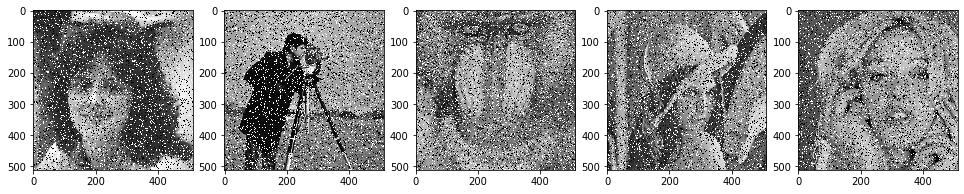

In [38]:
# Plotting images with Salt and Pepper Noise
plot_func(images_noise_SnP, saveimage=False,x=1 , y=6)

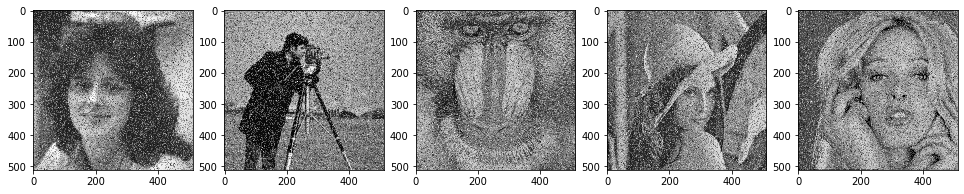

In [39]:
# Filtering Salt and Pepper noise on Natural images using Weiner Filter

images_filt_weinSnP = np.zeros(images_noise_SnP.shape)
kernel = gaussian_kernel(2)

for i in range (len(images_noise_SnP)):
    images_filt_weinSnP[i] = wiener_filter(images_noise_SnP[i], kernel, K = 20)

plot_func(images_filt_weinSnP, saveimage=True, savename='Weinerfilter_Natural_SnP.png',x=1,y=6)

In [40]:
# Evaluating performance
print('Performance of Weiner Filter on Natural images corrupted by Salt and Pepper Noise-->')
ssim_weinSnP = 0
ssim_weinSnP_list=[]
psnr_weinSnP_list=[]

for i in range (len(images)):
    ssim_weinSnP = measure.compare_ssim(images_filt_weinSnP[i], images[i])
    ssim_weinSnP_list.append(ssim_weinSnP)
    psnr_weinSnP = measure.compare_psnr(images[i], images_filt_weinSnP[i]) 
    psnr_weinSnP_list.append(psnr_weinSnP)
    print('For', i, 'image')
    print('SSIM: ',ssim_weinSnP)
    print('PSNR: ', psnr_weinSnP)
    
avg_ssim = np.sum(ssim_weinSnP_list)/len(ssim_weinSnP_list)
print('Average SSIM', avg_ssim)
avg_psnr = np.sum(psnr_weinSnP_list)/len(ssim_weinSnP_list)
print('Average PSNR', avg_psnr)

Performance of Weiner Filter on Natural images corrupted by Salt and Pepper Noise-->
For 0 image
SSIM:  0.004821313564384716
PSNR:  6.660090952803914


C:\Users\sahil\anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  
C:\Users\sahil\anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
  # Remove the CWD from sys.path while we load stuff.


For 1 image
SSIM:  0.0055507190578090405
PSNR:  6.0248274558263955
For 2 image
SSIM:  0.005596250096143637
PSNR:  5.966775757672878
For 3 image
SSIM:  0.004665517872492532
PSNR:  6.069231654280265
For 4 image
SSIM:  0.004451208109645098
PSNR:  5.520381526567713
Average SSIM 0.0050170017400950045
Average PSNR 6.0482614694302335


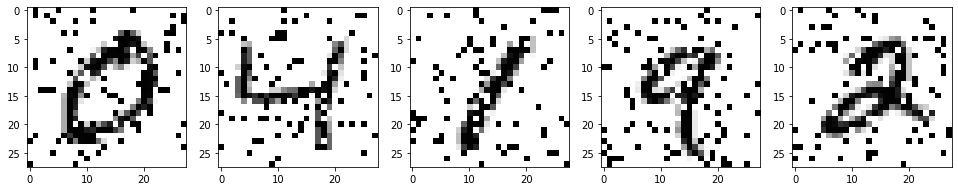

In [80]:
# Plotting images with SnP Noise
plot_func(mnist_noise_SnP, saveimage=False, x=1, y=6)

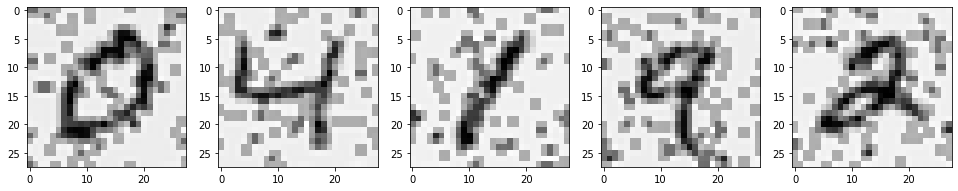

In [81]:
# Filtering Salt and Pepper noise on MNIST images using Weiner Filter

mnist_filt_weinSnP = np.zeros(mnist_noise_SnP.shape)
kernel = gaussian_kernel(2)

for i in range (len(mnist_noise_SnP)):
    mnist_filt_weinSnP[i] = wiener_filter(mnist_noise_SnP[i], kernel, K = 3)

plot_func(mnist_filt_weinSnP, saveimage=True, savename='Weinerfilter_MNIST_SnP.png',x=1,y=6)

In [42]:
# Evaluating performance
print('Performance of Weiner Filter on MNIST images corrupted by Salt and Pepper Noise-->')
ssim_weinSnP_mnist = 0
ssim_weinSnP_mnist_list=[]
psnr_weinSnP_mnist_list=[]

for i in range (len(x_mnist)):
    ssim_weinSnP_mnist = measure.compare_ssim(mnist_filt_weinSnP[i], x_mnist[i])
    ssim_weinSnP_mnist_list.append(ssim_weinSnP_mnist)
    psnr_weinSnP_mnist = measure.compare_psnr(x_mnist[i], mnist_filt_weinSnP[i]) 
    psnr_weinSnP_mnist_list.append(psnr_weinSnP_mnist)
    print('For', i, 'image')
    print('SSIM: ',ssim_weinSnP_mnist)
    print('PSNR: ', psnr_weinSnP_mnist)

Performance of Weiner Filter on MNIST images corrupted by Salt and Pepper Noise-->
For 0 image
SSIM:  0.12180217953253887
PSNR:  3.01330986042951
For 1 image
SSIM:  0.08814846231606484
PSNR:  2.730761060918297
For 2 image
SSIM:  0.07229369599177744
PSNR:  2.6235702947837387
For 3 image
SSIM:  0.08561256360180358
PSNR:  2.74569911019457
For 4 image
SSIM:  0.10670004545055768
PSNR:  2.970358630662347


C:\Users\sahil\anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  
C:\Users\sahil\anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
  # Remove the CWD from sys.path while we load stuff.


# Median Filter

## a) Filtering Gaussian Noise

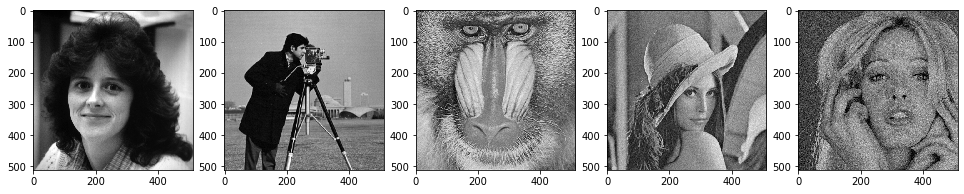

In [43]:
# Plotting images with Gaussian Noise
plot_func(images_noisy_G, saveimage=False,x=1,y=6)

<Figure size 1440x216 with 0 Axes>

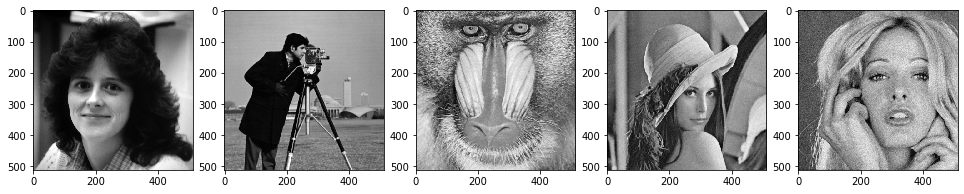

In [44]:
# Applying Median Filter to Gaussian Noise images

images_filt_medG = np.zeros(images_noisy_G.shape)

plt.figure(figsize = (20,3))
for i in range (len(images_noisy_G)):
    images_filt_medG[i] = ndimage.median_filter(images_noisy_G[i], 3)
    
plot_func(images_filt_medG, saveimage=True, savename='MedianFilter_Natural_Gaussian.png', x=1, y=6)

In [45]:
# Evaluating performance
print('Performance of Median Filter on Natural images corrupted by Gaussian Noise -->')
ssim_medG = 0
ssim_medG_list=[]
psnr_medG_list=[]
for i in range (len(images)):
    ssim_medG = measure.compare_ssim(images_filt_medG[i], images[i])
    ssim_medG_list.append(ssim_medG)
    #ssim_wein +=ssim_wein
    #avg = ssim_wein/(len(x_img_5))   
    psnr_medG = measure.compare_psnr(images[i], images_filt_medG[i]) 
    psnr_medG_list.append(psnr_medG)
    print('For', i, 'image')
    print('SSIM: ',ssim_medG)
    print('PSNR: ', psnr_medG)
    
avg_ssim = np.sum(ssim_medG_list)/len(ssim_medG_list)
print('Average SSIM', avg_ssim)
avg_psnr = np.sum(psnr_medG_list)/len(ssim_medG_list)
print('Average PSNR', avg_psnr)

Performance of Median Filter on Natural images corrupted by Gaussian Noise -->
For 0 image
SSIM:  0.803789779266351
PSNR:  41.75246814779116


C:\Users\sahil\anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  import sys
C:\Users\sahil\anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
  # This is added back by InteractiveShellApp.init_path()


For 1 image
SSIM:  0.763408445283362
PSNR:  36.48072320093635
For 2 image
SSIM:  0.8716504949405073
PSNR:  29.552590308525716
For 3 image
SSIM:  0.5707251535858321
PSNR:  32.1955356992277
For 4 image
SSIM:  0.3836713278871702
PSNR:  25.789050815534583
Average SSIM 0.6786490401926445
Average PSNR 33.154073634403105


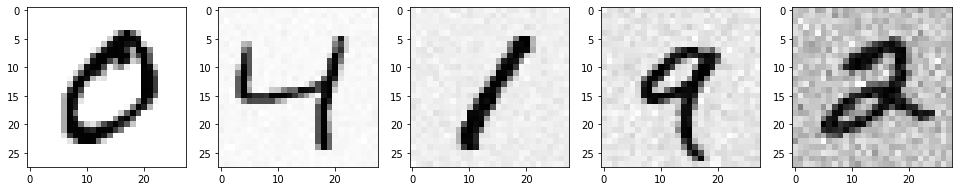

In [82]:
# Plotting images with Gaussian Noise
plot_func(mnist_noisy_G, saveimage=False, x=1, y=6)

<Figure size 1440x216 with 0 Axes>

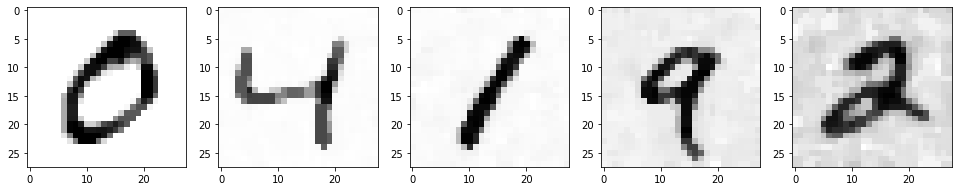

In [83]:
# Applying Median Filter on MNIST images corrupted by Gaussian Noise

mnist_filt_medG = np.zeros(mnist_noisy_G.shape)

plt.figure(figsize = (20,3))
for i in range (len(mnist_noisy_G)):
    mnist_filt_medG[i] = ndimage.median_filter(mnist_noisy_G[i], 3)
    
plot_func(mnist_filt_medG, saveimage=True, savename='MedianFilter_MNIST_Gaussian.png', x=1, y=6)

In [47]:
# Evaluating performance
print('Performance of Median Filter on MNIST images corrupted by Gaussian Noise -->')
ssim_medG_mnist = 0
ssim_medG_mnist_list=[]
psnr_medG_mnist_list=[]
for i in range (len(x_mnist)):
    ssim_medG_mnist = measure.compare_ssim(mnist_filt_medG[i], x_mnist[i])
    ssim_medG_mnist_list.append(ssim_medG_mnist)
    #ssim_wein +=ssim_wein
    #avg = ssim_wein/(len(x_img_5))   
    psnr_medG_mnist = measure.compare_psnr(x_mnist[i], mnist_filt_medG[i]) 
    psnr_medG_mnist_list.append(psnr_medG_mnist)
    print('For', i, 'image')
    print('SSIM: ',ssim_medG_mnist)
    print('PSNR: ', psnr_medG_mnist)

Performance of Median Filter on MNIST images corrupted by Gaussian Noise -->
For 0 image
SSIM:  0.9689923546303699
PSNR:  24.37822775746254
For 1 image
SSIM:  0.6678690147857996
PSNR:  20.962607960357435
For 2 image
SSIM:  0.588284231113056
PSNR:  26.427784878302166
For 3 image
SSIM:  0.6810381186449159
PSNR:  22.52988346492515
For 4 image
SSIM:  0.7871349277310103
PSNR:  20.422982075465228


C:\Users\sahil\anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  import sys
C:\Users\sahil\anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
  # This is added back by InteractiveShellApp.init_path()


## b) Filtering Poisson Noise

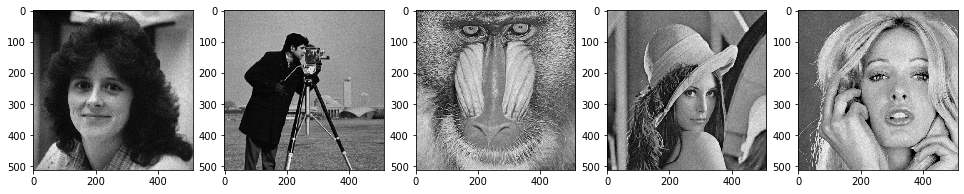

In [48]:
# Plotting images with Poisson Noise
plot_func(images_noise_P, saveimage=False, x=1, y=6)

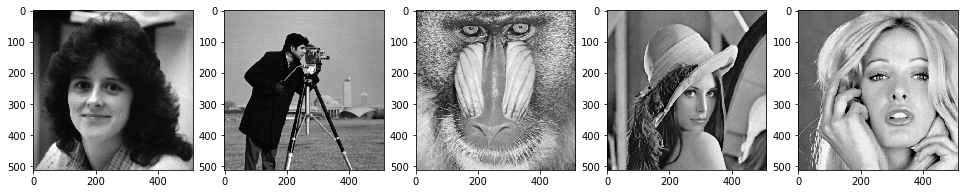

In [49]:
# Applying Median Filter to Poisson Noise images

images_filt_medP = np.zeros(images_noise_P.shape)

#plt.figure(figsize = (20,3))
for i in range (len(images_inv)):
    images_filt_medP[i] = ndimage.median_filter(images_noise_P[i], 3)
    
plot_func(images_filt_medP, saveimage=True, savename='MedianFilter_Natural_Poisson.png',x=1,y=6)

In [50]:
# Evaluating performance

print('Performance of Median Filter on Natural images corrupted by Poisson Noise-->')
ssim_medP = 0
ssim_medP_list = []
psnr_medP_list = []
for i in range (len(images_inv)):
    ssim_medP = measure.compare_ssim(images_filt_medP[i], images[i])
    ssim_medP_list.append(ssim_medP)
    #ssim_wein +=ssim_wein
    #avg = ssim_wein/(len(x_img_5))  
    psnr_medP = measure.compare_psnr(images[i], images_filt_medP[i]) 
    psnr_medP_list.append(psnr_medP)
    print('For',i, 'image')
    print('SSIM: ',ssim_medP)
    print('PSNR: ', psnr_medP)

Performance of Median Filter on Natural images corrupted by Poisson Noise-->
For 0 image
SSIM:  0.43192923007385015
PSNR:  6.260002885789286
For 1

C:\Users\sahil\anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  
C:\Users\sahil\anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
  if sys.path[0] == '':


 image
SSIM:  0.419342263196301
PSNR:  5.647868780287619
For 2 image
SSIM:  0.6398235777156022
PSNR:  5.623644103125798
For 3 image
SSIM:  0.4516563632602862
PSNR:  5.685624968181938
For 4 image
SSIM:  0.4617404650292267
PSNR:  5.108557832548474


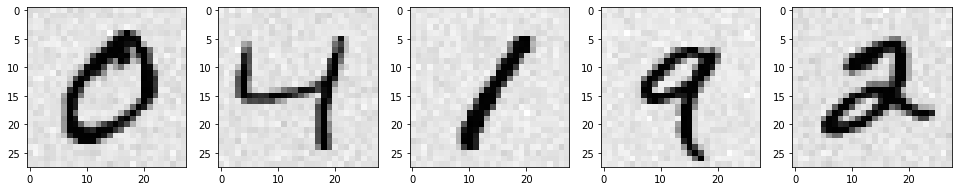

In [84]:
# Plotting images with Poisson Noise
plot_func(mnist_noise_P, saveimage=False, x=1, y=6)

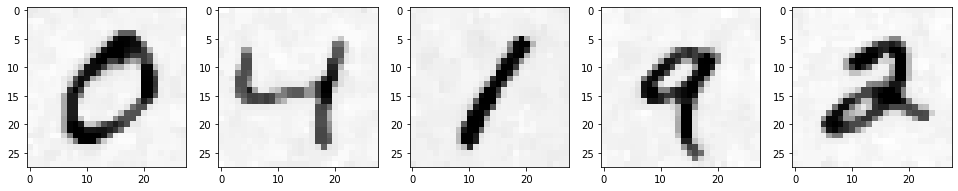

In [51]:
# Applying Median Filter to Poisson Noise images

mnist_filt_medP = np.zeros(mnist_noise_P.shape)

#plt.figure(figsize = (20,3))
for i in range (len(x_mnist)):
    mnist_filt_medP[i] = ndimage.median_filter(mnist_noise_P[i], 3)
    
plot_func(mnist_filt_medP, saveimage=True, savename='MedianFilter_MNIST_Poisson.png',x=1,y=6)

In [52]:
# Evaluating performance

print('Performance of Median Filter on MNIST images corrupted by Poisson Noise-->')
ssim_medP_mnist = 0
ssim_medP_mnist_list = []
psnr_medP_mnist_list = []
for i in range (len(x_mnist)):
    ssim_medP_mnist = measure.compare_ssim(mnist_filt_medP[i], x_mnist[i])
    ssim_medP_mnist_list.append(ssim_medP_mnist)
    #ssim_wein +=ssim_wein
    #avg = ssim_wein/(len(x_img_5))  
    psnr_medP_mnist = measure.compare_psnr(x_mnist[i], mnist_filt_medP[i]) 
    psnr_medP_mnist_list.append(psnr_medP_mnist)
    print('For',i, 'image')
    print('SSIM: ',ssim_medP_mnist)
    print('PSNR: ', psnr_medP_mnist)

Performance of Median Filter on MNIST images corrupted by Poisson Noise-->
For 0 image
SSIM:  0.5835342378702194
PSNR:  0.8713478502416887
For 1 image
SSIM:  0.4776951768596275
PSNR:  0.41639311655197736
For 2 image
SSIM:  0.37930626858333527
PSNR:  0.4417441871159999
For 3 image
SSIM:  0.46261351067630446
PSNR:  0.64177687511774
For 4 image
SSIM:  0.5578172598498282
PSNR:  0.8199445746353257


C:\Users\sahil\anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  
C:\Users\sahil\anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
  if sys.path[0] == '':


## c) Filtering Salt and Pepper noise

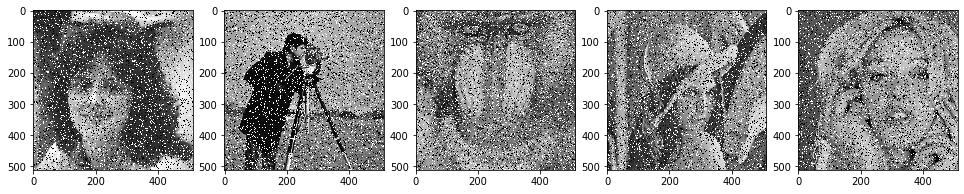

In [53]:
# Plotting images with Salt and Pepper Noise
plot_func(images_noise_SnP, saveimage=False,x=1 , y=6)

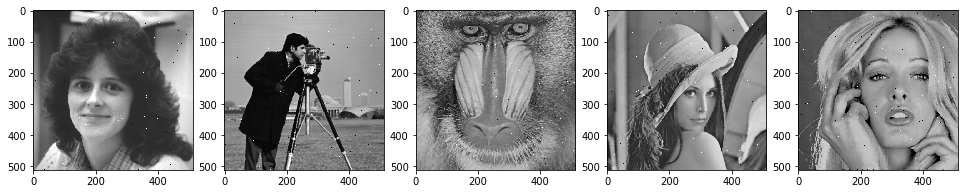

In [54]:
# Applying Median Filter to Poisson Noise images

images_filt_medSnP = np.zeros(images_noise_SnP.shape)

#plt.figure(figsize = (20,3))
for i in range (len(images)):
    images_filt_medSnP[i] = ndimage.median_filter(images_noise_SnP[i], 3)
    
plot_func(images_filt_medSnP, saveimage=True, savename='MedianFilter_Natural_SnP.png', x=1, y=6)

In [55]:
# Evaluating performance

print('Performance of Median Filter on Natural images corrupted by Salt and Pepper Noise-->')
ssim_medSnP = 0
ssim_medSnP_list = []
psnr_medSnP_list = []
for i in range (len(images)):
    ssim_medSnP = measure.compare_ssim(images_filt_medSnP[i], images[i])
    ssim_medSnP_list.append(ssim_medSnP)
    #ssim_wein +=ssim_wein
    #avg = ssim_wein/(len(x_img_5))  
    psnr_medSnP = measure.compare_psnr(images[i],images_filt_medP[i]) 
    psnr_medSnP_list.append(psnr_medSnP)
    print('For',i, 'image')
    print('SSIM: ',ssim_medSnP)
    print('PSNR: ', psnr_medSnP)

Performance of Median Filter on Natural images corrupted by Salt and Pepper Noise-->
For 0 image
SSIM:  0.7364976768910699
PSNR:  6.260002885789286
For

C:\Users\sahil\anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  
C:\Users\sahil\anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
  if sys.path[0] == '':


 1 image
SSIM:  0.7827662297914014
PSNR:  5.647868780287619
For 2 image
SSIM:  0.8308850036479275
PSNR:  5.623644103125798
For 3 image
SSIM:  0.6843990823206737
PSNR:  5.685624968181938
For 4 image
SSIM:  0.6365503608702178
PSNR:  5.108557832548474


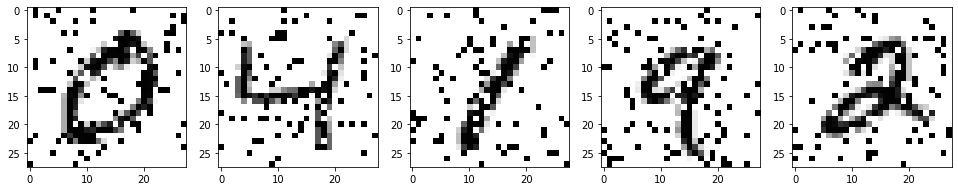

In [85]:
# Plotting images with SnP Noise
plot_func(mnist_noise_SnP, saveimage=False, x=1, y=6)

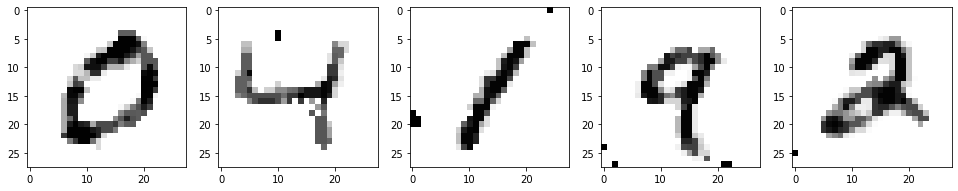

In [56]:
# Applying Median Filter to Poisson Noise images

mnist_filt_medSnP = np.zeros(mnist_noise_SnP.shape)

#plt.figure(figsize = (20,3))
for i in range (len(x_mnist)):
    mnist_filt_medSnP[i] = ndimage.median_filter(mnist_noise_SnP[i], 3)
    
plot_func(mnist_filt_medSnP, saveimage=True, savename='MedianFilter_MNIST_SnP.png', x=1, y=6)

In [57]:
# Evaluating performance

print('Performance of Median Filter on MNIST images corrupted by Salt and Pepper Noise-->')
ssim_medSnP_mnist = 0
ssim_medSnP_mnist_list = []
psnr_medSnP_mnist_list = []
for i in range (len(images)):
    ssim_medSnP_mnist = measure.compare_ssim(mnist_filt_medSnP[i], x_mnist[i])
    ssim_medSnP_mnist_list.append(ssim_medSnP_mnist)
    #ssim_wein +=ssim_wein
    #avg = ssim_wein/(len(x_img_5))  
    psnr_medSnP_mnist = measure.compare_psnr(x_mnist[i],mnist_filt_medP[i]) 
    psnr_medSnP_mnist_list.append(psnr_medSnP_mnist)
    print('For',i, 'image')
    print('SSIM: ',ssim_medSnP_mnist)
    print('PSNR: ', psnr_medSnP_mnist)

Performance of Median Filter on MNIST images corrupted by Salt and Pepper Noise-->
For 0 image
SSIM:  0.8683161520017723
PSNR:  0.8713478502416887
For 1 image
SSIM:  0.7719052284404084
PSNR:  0.41639311655197736
For 2 image
SSIM:  0.8690851953275445
PSNR:  0.4417441871159999
For 3 image
SSIM:  0.8523910684090843
PSNR:  0.64177687511774
For 4 image
SSIM:  0.854557847884031
PSNR:  0.8199445746353257


C:\Users\sahil\anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  
C:\Users\sahil\anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
  if sys.path[0] == '':


# Bilateral Filter

## a) Filtering Gaussian Noise 

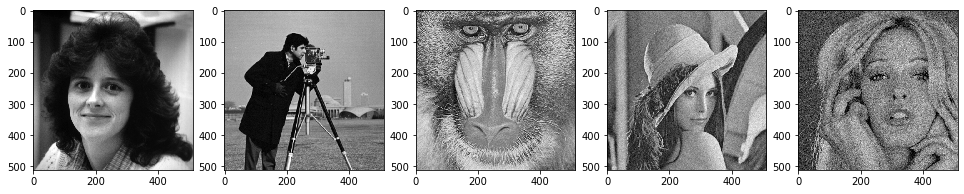

In [36]:
# Plotting images with Gaussian Noise
plot_func(images_noisy_G, saveimage=False,x=1,y=6)

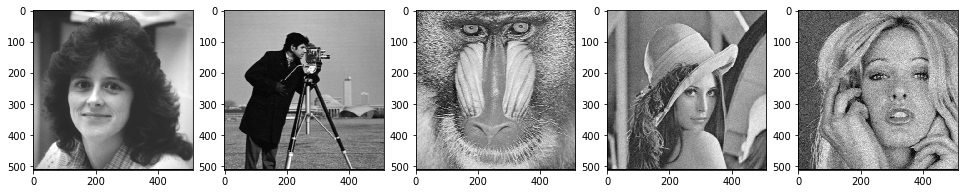

In [37]:
# Applying Bilateral Filter to Gaussian Noise images

images_filt_bilG = bilateral_filter(images_noisy_G)

# Plotting filtered images
plot_func(images_filt_bilG, saveimage=True, savename='BilateralFilter_Gaussian.png', x=1,y=6)

In [38]:
# Evaluating performance of Bilateral filter on Gaussian Noise Images

print('Performance of Bilateral Filter in Gaussian Noise images -->')
ssim_bilG = 0
ssim_bilG_list = []
psnr_bilG_list = []
for i in range (len(images)):
    ssim_bilG = measure.compare_ssim(images_filt_bilG[i], images[i])
    ssim_bilG_list.append(ssim_bilG)
    #ssim_wein +=ssim_wein
    #avg = ssim_wein/(len(x_img_5))   
    psnr_bilG = measure.compare_psnr(images[i], images_filt_bilG[i]) 
    psnr_bilG_list.append(psnr_bilG)
    print('For', i, 'image')
    print('SSIM: ',ssim_bilG)
    print('PSNR: ', psnr_bilG)

Performance of Bilateral Filter in Gaussian Noise images -->
For 0 image
SSIM:  0.48538252845613084
PSNR:  24.69414807052512
For 1 image
SSIM:  0.2463946802488072
PSNR:  22.53710991321261
For 2 image
SSIM:  0.19347816730044953
PSNR:  18.972037597172978
For 3 image
SSIM:  0.34295244311323136
PSNR:  23.764741775588206
For 4 image
SSIM:  0.19930222615690282
PSNR:  21.411153979170194


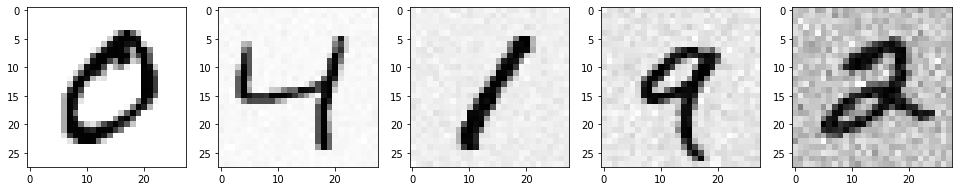

In [87]:
# Plotting images with Gaussian Noise
plot_func(mnist_noisy_G, saveimage=False, x=1, y=6)

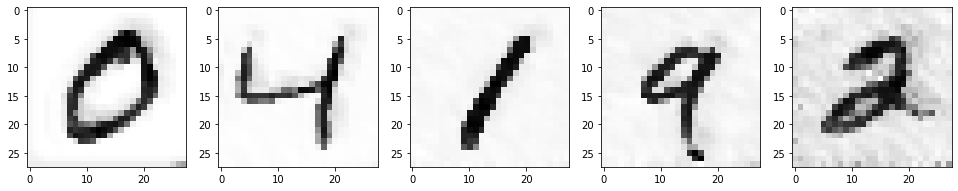

In [59]:
# Applying Bilateral Filter to Gaussian Noise MNIST images

mnist_filt_bilG = np.zeros(mnist_noisy_G.shape)

#plt.figure(figsize = (20,3))
mnist_filt_bilG = bilateral_filter(mnist_noisy_G)

    
plot_func(mnist_filt_bilG, saveimage=True, savename='BilateralFilter_MNIST_G.png', x=1, y=6)

In [60]:
# Evaluating performance of Bilateral filter on Gaussian Noise MNIST images

print('Performance of Bilateral Filter in Gaussian Noise images -->')
ssim_bilG_mnist = 0
ssim_bilG_mnist_list = []
psnr_bilG_mnist_list = []
for i in range (len(images)):
    ssim_bilG_mnist = measure.compare_ssim(mnist_filt_bilG[i], x_mnist[i])
    ssim_bilG_mnist_list.append(ssim_bilG_mnist)
    #ssim_wein +=ssim_wein
    #avg = ssim_wein/(len(x_img_5))   
    psnr_bilG_mnist = measure.compare_psnr(x_mnist[i], mnist_filt_bilG[i]) 
    psnr_bilG_mnist_list.append(psnr_bilG_mnist)
    print('For', i, 'image')
    print('SSIM: ',ssim_bilG_mnist)
    print('PSNR: ', psnr_bilG_mnist)

Performance of Bilateral Filter in Gaussian Noise images -->
For 0 image
SSIM:  0.8530413453933534
PSNR:  21.973104701452378
For 1 image
SSIM:  0.6895506240586711
PSNR:  22.769501497798714
For 2 image
SSIM:  0.5686011643532495
PSNR:  27.953228292232172
For 3 image
SSIM:  0.663100447741302
PSNR:  22.952687346434285
For 4 image
SSIM:  0.7447631028720711
PSNR:  18.723458390797667


C:\Users\sahil\anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  
C:\Users\sahil\anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
  if sys.path[0] == '':


## b) Filtering Poisson Noise

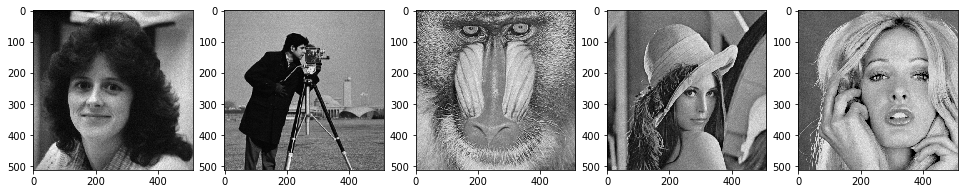

In [36]:
# Plotting images with Poisson Noise

plot_func(images_noise_P, saveimage=False, x=1, y=6)

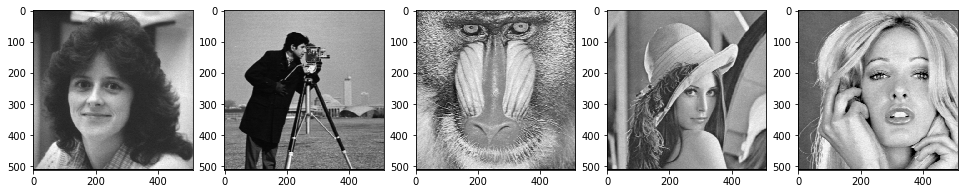

In [39]:
# Applying Bilateral Filter to Poisson Noise images

images_filt_bilP = np.zeros(images.shape)

#plt.figure(figsize = (20,3))
for i in range (len(images)):
    images_filt_bilP[i] = denoise_bilateral(images_noise_P[i], sigma_spatial = 1.2)
    
plot_func(images_filt_bilP, saveimage=True, savename='Bilateralfilter_Poisson.png',x=1, y=6)

In [40]:
# Evaluating performance

print('Performance of Bilateral Filter in Gaussian Noise images -->')
ssim_bilP = 0
ssim_bilP_list = []
psnr_bilP_list = []
for i in range (len(images)):
    ssim_bilP = measure.compare_ssim(images_filt_bilP[i], images[i])
    ssim_bilP_list.append(ssim_bilP)
    #ssim_wein +=ssim_wein
    #avg = ssim_wein/(len(x_img_5))   
    psnr_bilP = measure.compare_psnr(images[i], images_filt_bilP[i]) 
    psnr_bilP_list.append(psnr_bilP)
    print('For', i, 'image')
    print('SSIM: ',ssim_bilP)
    print('PSNR: ', psnr_bilP)

Performance of Bilateral Filter in Gaussian Noise images -->
For 0 image
SSIM:  0.21916738063164043
PSNR:  6.229116157948881
For 1 image
SSIM:  0.06766838414368179
PSNR:  5.534161565060877
For 2 image
SSIM:  0.019587959750958745
PSNR:  5.227632591282163
For 3 image
SSIM:  0.23312029051361857
PSNR:  5.614076234288782
For 4 image
SSIM:  0.1948321981196399
PSNR:  5.032956861859068


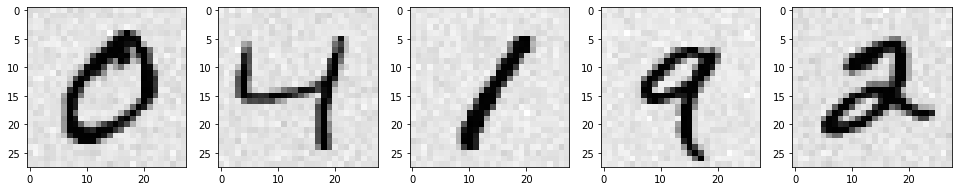

In [88]:
# Plotting images with Poisson Noise
plot_func(mnist_noise_P, saveimage=False, x=1, y=6)

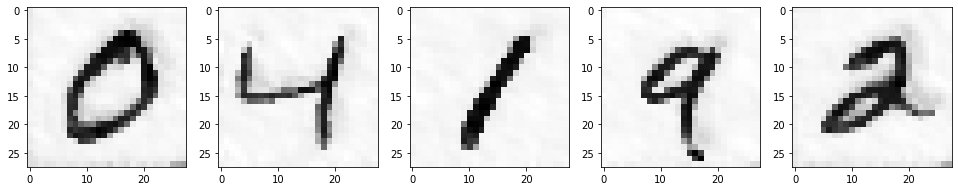

In [62]:
# Applying Bilateral Filter to Poisson Noise MNIST images

mnist_filt_bilP = np.zeros(mnist_noise_P.shape)

#plt.figure(figsize = (20,3))
mnist_filt_bilP = bilateral_filter(mnist_noise_P)

    
plot_func(mnist_filt_bilP, saveimage=True, savename='BilateralFilter_MNIST_P.png', x=1, y=6)

In [63]:
# Evaluating performance of Bilateral filter on Poisson Noise MNIST images

print('Performance of Bilateral Filter in Gaussian Noise images -->')
ssim_bilP_mnist = 0
ssim_bilP_mnist_list = []
psnr_bilP_mnist_list = []
for i in range (len(images)):
    ssim_bilP_mnist = measure.compare_ssim(mnist_filt_bilP[i], x_mnist[i])
    ssim_bilP_mnist_list.append(ssim_bilP_mnist)
    #ssim_wein +=ssim_wein
    #avg = ssim_wein/(len(x_img_5))   
    psnr_bilP_mnist = measure.compare_psnr(x_mnist[i], mnist_filt_bilP[i]) 
    psnr_bilP_mnist_list.append(psnr_bilP_mnist)
    print('For', i, 'image')
    print('SSIM: ',ssim_bilP_mnist)
    print('PSNR: ', psnr_bilP_mnist)

Performance of Bilateral Filter in Gaussian Noise images -->
For 0 image
SSIM:  0.5894708269202633
PSNR:  1.050719166291195
For 1 image
SSIM:  0.4875413505655097
PSNR:  0.5059481820840641
For 2 image
SSIM:  0.3736926526378866
PSNR:  0.45580987185694966
For 3 image
SSIM:  0.45734039074119165
PSNR:  0.7021380643270648
For 4 image
SSIM:  0.5577483390624184
PSNR:  0.9654752540212369


C:\Users\sahil\anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  
C:\Users\sahil\anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
  if sys.path[0] == '':


## c) Filtering Salt and Pepper

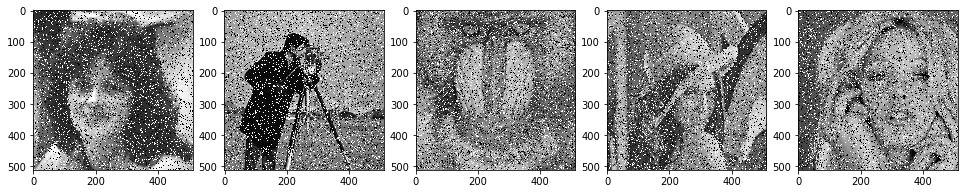

In [41]:
# Plotting images with Salt and Pepper Noise
plot_func(images_noise_SnP, saveimage=False,x=1 , y=6)

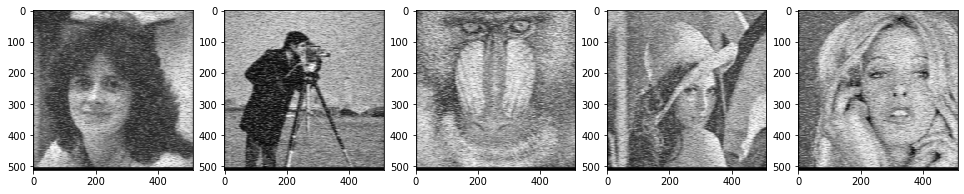

In [42]:
# Applying Bilateral Filter to Salt and Pepper Noise images

images_filt_bilSnP = np.zeros(images_noise_SnP.shape)

#plt.figure(figsize = (20,3))
for i in range (len(images)):
    images_filt_bilSnP[i] = denoise_bilateral(images_noise_SnP[i], sigma_spatial = 3)
    
plot_func(images_filt_bilSnP, saveimage=True, savename='BilateralFilter_SnP.png',x=1,y=6)

In [43]:
# Evaluating performance
print('Performance of Bilateral Filter in Salt and Pepper Noise images -->')
ssim_bilSnP = 0
ssim_bilSnP_list = []
psnr_bilSnP_list = []
for i in range (len(images)):
    ssim_bilSnP = measure.compare_ssim(images_filt_bilSnP[i], images[i])
    ssim_bilSnP_list.append(ssim_bilSnP)
    #ssim_wein +=ssim_wein
    #avg = ssim_wein/(len(x_img_5))   
    psnr_bilSnP = measure.compare_psnr(images[i], images_filt_bilSnP[i]) 
    psnr_bilSnP_list.append(psnr_bilSnP)
    print('For', i, 'image')
    print('SSIM: ',ssim_bilSnP)
    print('PSNR: ', psnr_bilSnP)

Performance of Bilateral Filter in Salt and Pepper Noise images -->
For 0 image
SSIM:  0.07189736759431829
PSNR:  17.402641486082093
For 1 image
SSIM:  0.02667456097900152
PSNR:  17.064590485830227
For 2 image
SSIM:  0.024911693675199475
PSNR:  17.051142341467344
For 3 image
SSIM:  0.08351542523678467
PSNR:  18.312601250740194
For 4 image
SSIM:  0.052863446080601256
PSNR:  17.834396078019417


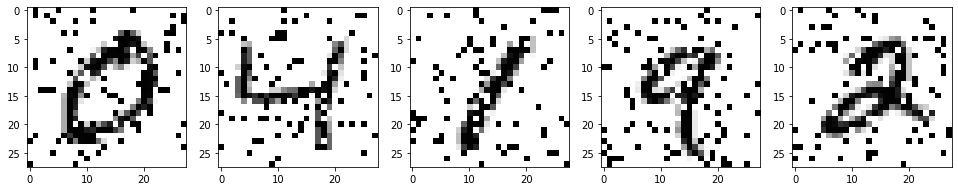

In [89]:
# Plotting images with SnP Noise
plot_func(mnist_noise_SnP, saveimage=False, x=1, y=6)

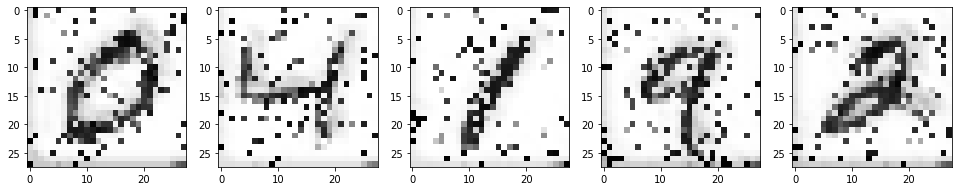

In [64]:
# Applying Bilateral Filter to SnP Noise MNIST images

mnist_filt_bilSnP = np.zeros(mnist_noise_SnP.shape)

#plt.figure(figsize = (20,3))
mnist_filt_bilSnP = bilateral_filter(mnist_noise_SnP)

    
plot_func(mnist_filt_bilSnP, saveimage=True, savename='BilateralFilter_MNIST_SnP.png', x=1, y=6)

In [65]:
# Evaluating performance of Bilateral filter on SnP Noise MNIST images

print('Performance of Bilateral Filter in Gaussian Noise images -->')
ssim_bilSnP_mnist = 0
ssim_bilSnP_mnist_list = []
psnr_bilSnP_mnist_list = []
for i in range (len(images)):
    ssim_bilSnP_mnist = measure.compare_ssim(mnist_filt_bilSnP[i], x_mnist[i])
    ssim_bilSnP_mnist_list.append(ssim_bilSnP_mnist)
    #ssim_wein +=ssim_wein
    #avg = ssim_wein/(len(x_img_5))   
    psnr_bilSnP_mnist = measure.compare_psnr(x_mnist[i], mnist_filt_bilSnP[i]) 
    psnr_bilSnP_mnist_list.append(psnr_bilSnP_mnist)
    print('For', i, 'image')
    print('SSIM: ',ssim_bilSnP_mnist)
    print('PSNR: ', psnr_bilSnP_mnist)

Performance of Bilateral Filter in Gaussian Noise images -->
For 0 image
SSIM:  0.5787213916915631
PSNR:  11.18501783009193
For 1 image
SSIM:  0.4167109580341826
PSNR:  11.179550891421208
For 2 image
SSIM:  0.37745249653866164
PSNR:  11.689960236592354
For 3 image
SSIM:  0.42573858961507866
PSNR:  10.668961134252585
For 4 image
SSIM:  0.5250028876923474
PSNR:  11.06095708283183


C:\Users\sahil\anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  
C:\Users\sahil\anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
  if sys.path[0] == '':


# Non- Local Means Filter

## a) Filtering Gaussian Noise 

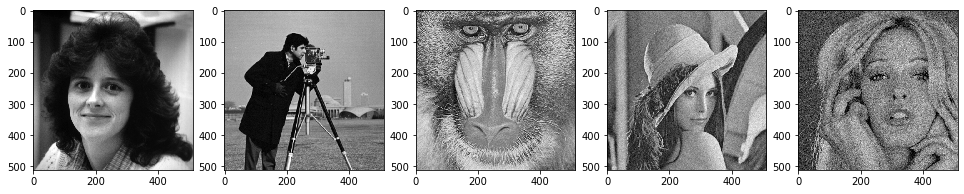

In [44]:
# Plotting images with Gaussian Noise
plot_func(images_noisy_G, saveimage=False,x=1,y=6)

Estimated noise standard deviation = { 7.182944144687335 }


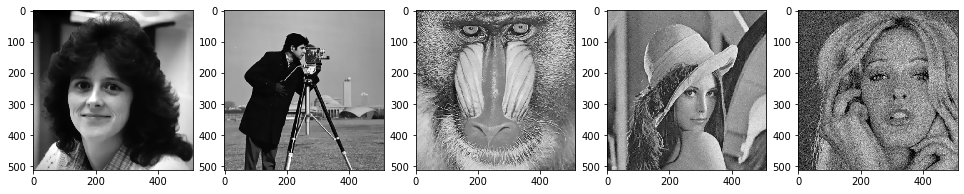

In [47]:
# Applying slow NLM to Gaussian Noise images

patch = dict(patch_size=5, patch_distance=6, multichannel=True) # 5x5 patches # 13x13 search area
# estimate the noise standard deviation from the noisy image
sigma_est = np.mean(estimate_sigma(images_noisy_G, multichannel=True))
print("Estimated noise standard deviation = {",sigma_est,"}")
images_filt_nlmG = np.zeros(images_noisy_G.shape)

#plt.figure(figsize = (20,3))
for i in range (len(images)):
    images_filt_nlmG[i] = denoise_nl_means(images_noisy_G[i], h=1.15 * sigma_est, fast_mode=False, **patch)

plot_func(images_filt_nlmG, saveimage=True, savename='NLMFilter_Gaussian.png', x=1, y=6)

In [48]:
# Evaluating performance of NLM on Gaussian noise images:

print('Performance of NLM Filter in Gaussian Noise images -->')
ssim_nlmG = 0
ssim_nlmG_list = []
psnr_nlmG_list = []

for i in range (len(images)):
    ssim_nlmG = measure.compare_ssim(images_filt_nlmG[i], images[i])
    ssim_nlmG_list.append(ssim_nlmG)
    #ssim_wein +=ssim_wein
    #avg = ssim_wein/(len(x_img_5))   
    psnr_nlmG = measure.compare_psnr(images[i], images_filt_nlmG[i]) 
    psnr_nlmG_list.append(psnr_nlmG)
    print('For', i, 'image')
    print('SSIM: ',ssim_nlmG)
    print('PSNR: ', psnr_nlmG)

Performance of NLM Filter in Gaussian Noise images -->
For 0 image
SSIM:  0.6553903912438259
PSNR:  40.774542527431315
For 1 image
SSIM:  0.5674445708001465
PSNR:  41.076522598795336
For 2 image
SSIM:  0.9244327065501118
PSNR:  35.80713897721737
For 3 image
SSIM:  0.5619189386557024
PSNR:  31.006081989360624
For 4 image
SSIM:  0.2659530970293202
PSNR:  20.18865847733652


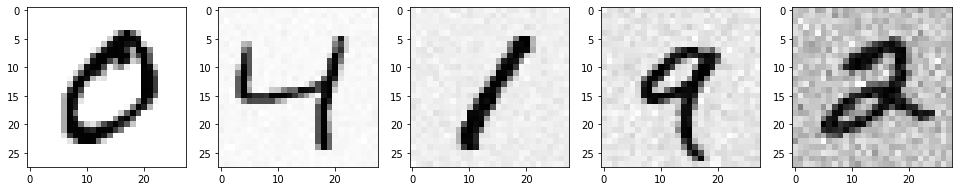

In [90]:
# Plotting images with Gaussian Noise
plot_func(mnist_noisy_G, saveimage=False, x=1, y=6)

Performance of Bilateral Filter in Gaussian Noise images -->
For 0 image
SSIM:  0.8530413453933534
PSNR:  21.973104701452378
For 1 image
SSIM:  0.6895506240586711
PSNR:  22.769501497798714
For 2 image
SSIM:  0.5686011643532495
PSNR:  27.953228292232172
For 3 image
SSIM:  0.663100447741302
PSNR:  22.952687346434285
For 4 image
SSIM:  0.7447631028720711
PSNR:  18.723458390797667


C:\Users\sahil\anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\sahil\anaconda3\lib\site-packages\ipykernel_launcher.py:22: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.


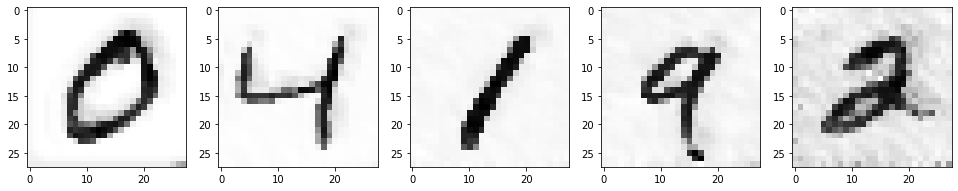

In [66]:
# Applying NLM Filter to Gaussian Noise MNIST images

mnist_filt_nlmG = np.zeros(mnist_noisy_G.shape)

#plt.figure(figsize = (20,3))
mnist_filt_nlmG = bilateral_filter(mnist_noisy_G)

    
plot_func(mnist_filt_nlmG, saveimage=True, savename='NLMFilter_MNIST_G.png', x=1, y=6)

# Evaluating performance of NLM filter on Gaussian Noise MNIST images

print('Performance of Bilateral Filter in Gaussian Noise images -->')
ssim_nlmG_mnist = 0
ssim_nlmG_mnist_list = []
psnr_nlmG_mnist_list = []
for i in range (len(images)):
    ssim_nlmG_mnist = measure.compare_ssim(mnist_filt_nlmG[i], x_mnist[i])
    ssim_nlmG_mnist_list.append(ssim_nlmG_mnist)
    #ssim_wein +=ssim_wein
    #avg = ssim_wein/(len(x_img_5))   
    psnr_nlmG_mnist = measure.compare_psnr(x_mnist[i], mnist_filt_nlmG[i]) 
    psnr_nlmG_mnist_list.append(psnr_nlmG_mnist)
    print('For', i, 'image')
    print('SSIM: ',ssim_nlmG_mnist)
    print('PSNR: ', psnr_nlmG_mnist)

## b) Filtering Poisson Noise 

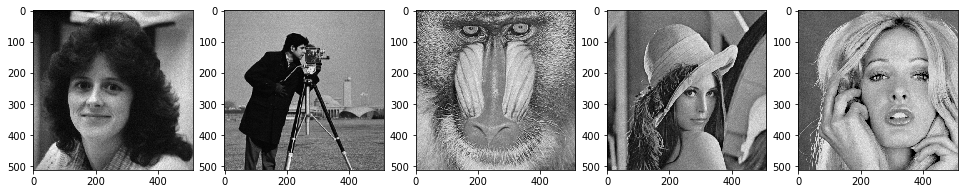

In [46]:
# Plotting images with Poisson Noise
plot_func(images_noise_P, saveimage=False, x=1, y=6)

estimated noise standard deviation = 11.357523630922957


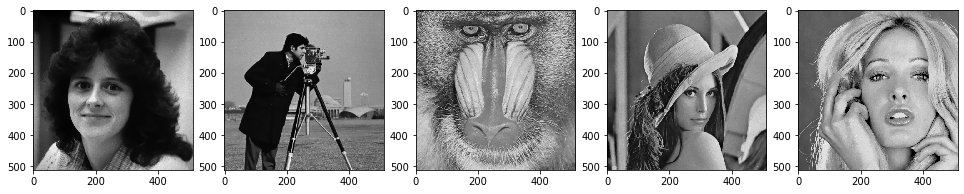

In [47]:
# Applying slow NLM to Poisson Noise images

patch = dict(patch_size=5, patch_distance=6, multichannel=True) # 5x5 patches # 13x13 search area
# estimate the noise standard deviation from the noisy image
sigma_est = np.mean(estimate_sigma(images_noise_P, multichannel=True))
print(f"estimated noise standard deviation = {sigma_est}")
images_filt_nlmP = np.zeros(images_noise_P.shape)

plt.figure(figsize = (20,3))
for i in range (len(images)):
    #x_noise_G[i] = img_as_float(x_noise_G[i])
    images_filt_nlmP[i] = denoise_nl_means(images_noise_P[i], h=1.15 * sigma_est, fast_mode=False, **patch)
    x = plt.subplot(1,6,i+1)
    plt.savefig("NLM Filter + Poisson Noise.png", bbox_inches = 'tight', format = 'png')
    plt.imshow(images_filt_nlmP[i], cmap = 'gray')

In [63]:
# Evaluating performance of NLM filter on Poisson noise;

print('Performance of Median Filter in Gaussian Noise images -->')
ssim_nlmP = 0
ssim_nlmP_list = []
psnr_nlmP_list = []

for i in range (len(images)):
    ssim_nlmP = measure.compare_ssim(images_filt_nlmP[i], images[i])
    ssim_nlmP_list.append(ssim_nlmP)
    #ssim_wein +=ssim_wein
    #avg = ssim_wein/(len(x_img_5))   
    psnr_nlmP = measure.compare_psnr(images[i], images_filt_nlmP[i]) 
    psnr_nlmP_list.append(psnr_nlmP)
    print('For', i, 'image')
    print('SSIM: ',ssim_nlmP)
    print('PSNR: ', psnr_nlmP)

Performance of Median Filter in Gaussian Noise images -->
For 0 image
SSIM:  0.47975520110285214
PSNR:  6.24838870982585
For 1 image
SSIM:  0.3863685798222979
PSNR:  5.6123092291210455
For 2 image
SSIM:  0.5887350548043956
PSNR:  5.537203081681069


C:\Users\sahil\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  if __name__ == '__main__':
C:\Users\sahil\anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
  del sys.path[0]


For 3 image
SSIM:  0.49476504967236196
PSNR:  5.654377292526151
For 4 image
SSIM:  0.5128044501372576
PSNR:  5.09697226252582


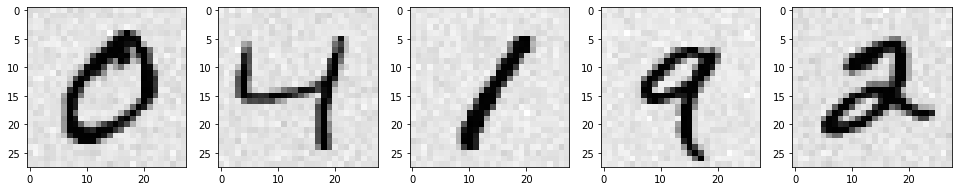

In [91]:
# Plotting images with Poisson Noise
plot_func(mnist_noise_P, saveimage=False, x=1, y=6)

Performance of Bilateral Filter in Gaussian Noise images -->
For 0 image
SSIM:  0.5894708269202633
PSNR:  1.050719166291195
For 1 image
SSIM:  0.4875413505655097
PSNR:  0.5059481820840641
For 2 image
SSIM:  0.3736926526378866
PSNR:  0.45580987185694966
For 3 image
SSIM:  0.45734039074119165
PSNR:  0.7021380643270648
For 4 image
SSIM:  0.5577483390624184
PSNR:  0.9654752540212369


C:\Users\sahil\anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\sahil\anaconda3\lib\site-packages\ipykernel_launcher.py:22: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.


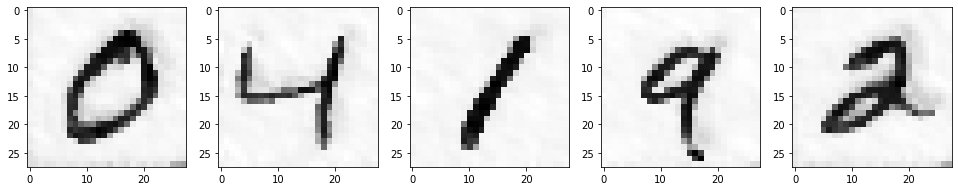

In [67]:
# Applying NLM Filter to Poisson Noise MNIST images

mnist_filt_nlmP = np.zeros(mnist_noise_P.shape)

#plt.figure(figsize = (20,3))
mnist_filt_nlmP = bilateral_filter(mnist_noise_P)

    
plot_func(mnist_filt_nlmP, saveimage=True, savename='NLMFilter_MNIST_P.png', x=1, y=6)

# Evaluating performance of NLM filter on Poisson Noise MNIST images

print('Performance of Bilateral Filter in Gaussian Noise images -->')
ssim_nlmP_mnist = 0
ssim_nlmP_mnist_list = []
psnr_nlmP_mnist_list = []
for i in range (len(images)):
    ssim_nlmP_mnist = measure.compare_ssim(mnist_filt_nlmP[i], x_mnist[i])
    ssim_nlmP_mnist_list.append(ssim_nlmP_mnist)
    #ssim_wein +=ssim_wein
    #avg = ssim_wein/(len(x_img_5))   
    psnr_nlmP_mnist = measure.compare_psnr(x_mnist[i], mnist_filt_nlmP[i]) 
    psnr_nlmP_mnist_list.append(psnr_nlmP_mnist)
    print('For', i, 'image')
    print('SSIM: ',ssim_nlmP_mnist)
    print('PSNR: ', psnr_nlmP_mnist)

## c) Filtering Salt and Pepper Noise 

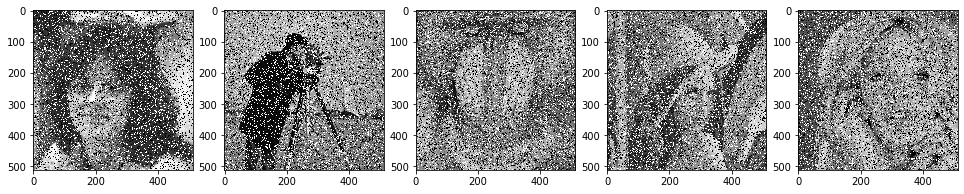

In [50]:
# Plotting images with Salt and Pepper Noise
plot_func(images_noise_SnP, saveimage=False,x=1 , y=6)

Estimated noise standard deviation = 36.72467181363332


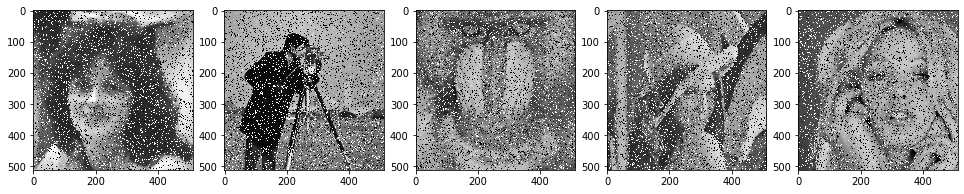

In [49]:
# Applying slow NLM to Salt and Pepper Noise images

patch = dict(patch_size=5, patch_distance=6, multichannel=True) # 5x5 patches # 13x13 search area
# estimate the noise standard deviation from the noisy image
sigma_est = np.mean(estimate_sigma(images_noise_SnP, multichannel=True))
print(f"Estimated noise standard deviation = {sigma_est}")

images_filt_nlmSnP = np.zeros(images_noise_SnP.shape)

#plt.figure(figsize = (20,3))
for i in range (len(images)):
    images_filt_nlmSnP[i] = denoise_nl_means(images_noise_SnP[i], h=1.15 * sigma_est, fast_mode=False, **patch)
plot_func(images_filt_nlmSnP, saveimage=True, savename='NLMFilter_SnP.png', x=1, y=6)

In [52]:
# Evaluating performance of NLM filter on Salt and Ppper noise;

print('Performance of NLM Filter in Salt and Pepper Noise images -->')
ssim_nlmSnP = 0
ssim_nlmSnP_list = []
psnr_nlmSnP_list = []
for i in range (len(images)):
    ssim_nlmSnP = measure.compare_ssim(images_filt_nlmSnP[i], images[i])
    ssim_nlmSnP_list.append(ssim_nlmSnP)
    #ssim_wein +=ssim_wein
    #avg = ssim_wein/(len(x_img_5))   
    psnr_nlmSnP = measure.compare_psnr(images[i], images_filt_nlmSnP[i]) 
    psnr_nlmSnP_list.append(psnr_nlmSnP)
    print('For', i, 'image')
    print('SSIM: ',ssim_nlmSnP)
    print('PSNR: ', psnr_nlmSnP)

Performance of Median Filter in Gaussian Noise images -->
For 0 image
SSIM:  0.032877314435004946
PSNR:  11.261768997858699
For 1 image
SSIM:  0.0723266123318321
PSNR:  11.750756917217176
For 2 image
SSIM:  0.14195077508114798
PSNR:  14.020209670893962


C:\Users\sahil\anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  
C:\Users\sahil\anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
  if sys.path[0] == '':


For 3 image
SSIM:  0.06746141714510552
PSNR:  12.808636755143361
For 4 image
SSIM:  0.0792042193652007
PSNR:  12.947253691428987


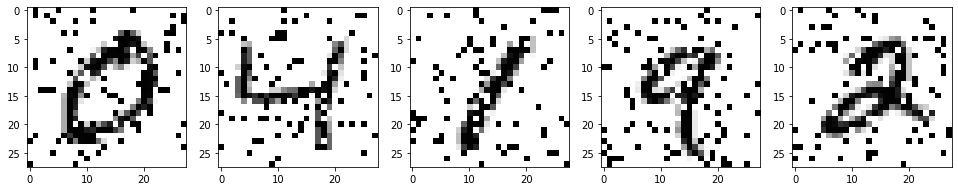

In [92]:
# Plotting images with SnP Noise
plot_func(mnist_noise_SnP, saveimage=False, x=1, y=6)

Performance of Bilateral Filter in Gaussian Noise images -->
For 0 image
SSIM:  0.5787213916915631
PSNR:  11.18501783009193
For 1 image
SSIM:  0.4167109580341826
PSNR:  11.179550891421208
For 2 image
SSIM:  0.37745249653866164
PSNR:  11.689960236592354
For 3 image
SSIM:  0.42573858961507866
PSNR:  10.668961134252585
For 4 image
SSIM:  0.5250028876923474
PSNR:  11.06095708283183


C:\Users\sahil\anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\sahil\anaconda3\lib\site-packages\ipykernel_launcher.py:22: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.


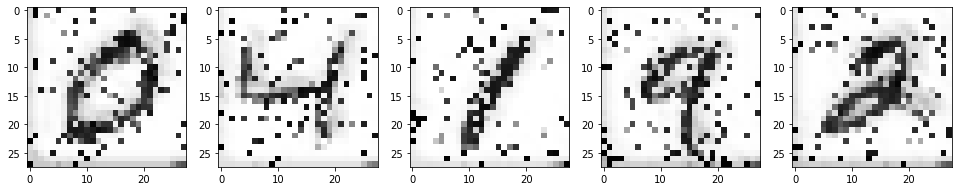

In [68]:
# Applying NLM Filter to SnP Noise MNIST images

mnist_filt_nlmSnP = np.zeros(mnist_noise_SnP.shape)

#plt.figure(figsize = (20,3))
mnist_filt_nlmSnP = bilateral_filter(mnist_noise_SnP)

    
plot_func(mnist_filt_nlmSnP, saveimage=True, savename='NLMFilter_MNIST_SnP.png', x=1, y=6)

# Evaluating performance of NLM filter on SnP Noise MNIST images

print('Performance of Bilateral Filter in Gaussian Noise images -->')
ssim_nlmSnP_mnist = 0
ssim_nlmSnP_mnist_list = []
psnr_nlmSnP_mnist_list = []
for i in range (len(images)):
    ssim_nlmSnP_mnist = measure.compare_ssim(mnist_filt_nlmSnP[i], x_mnist[i])
    ssim_nlmSnP_mnist_list.append(ssim_nlmSnP_mnist)
    #ssim_wein +=ssim_wein
    #avg = ssim_wein/(len(x_img_5))   
    psnr_nlmSnP_mnist = measure.compare_psnr(x_mnist[i], mnist_filt_nlmSnP[i]) 
    psnr_nlmSnP_mnist_list.append(psnr_nlmSnP_mnist)
    print('For', i, 'image')
    print('SSIM: ',ssim_nlmSnP_mnist)
    print('PSNR: ', psnr_nlmSnP_mnist)

# Plotting SSIM and PSNR for MNIST data

In [70]:
# Finding average of SSIM and PSNR

ssim_weiner = [ np.sum(ssim_weinG_mnist_list)/len(ssim_weinG_mnist_list) , np.sum(ssim_weinP_mnist_list)/len(ssim_weinP_mnist_list), 
              np.sum(ssim_weinSnP_mnist_list)/len(ssim_weinSnP_mnist_list)]

psnr_weiner = [ np.sum(psnr_weinG_mnist_list)/len(psnr_weinG_mnist_list) , np.sum(psnr_weinP_mnist_list)/len(psnr_weinP_mnist_list), 
              np.sum(psnr_weinSnP_mnist_list)/len(psnr_weinSnP_mnist_list)]


ssim_bil = [ np.sum(ssim_bilG_mnist_list)/len(ssim_bilG_mnist_list) , np.sum(ssim_bilP_mnist_list)/len(ssim_bilP_mnist_list), 
              np.sum(ssim_bilSnP_mnist_list)/len(ssim_bilSnP_mnist_list)]

psnr_bil = [ np.sum(psnr_bilG_mnist_list)/len(psnr_bilG_mnist_list) , np.sum(psnr_bilP_mnist_list)/len(psnr_bilP_mnist_list), 
              np.sum(psnr_bilSnP_mnist_list)/len(psnr_bilSnP_mnist_list)]


ssim_med = [ np.sum(ssim_medG_mnist_list)/len(ssim_medG_mnist_list) , np.sum(ssim_medP_mnist_list)/len(ssim_medP_mnist_list), 
              np.sum(ssim_medSnP_mnist_list)/len(ssim_medSnP_mnist_list)]

psnr_med = [ np.sum(psnr_medG_mnist_list)/len(psnr_medG_mnist_list) , np.sum(psnr_medP_mnist_list)/len(psnr_medP_mnist_list), 
              np.sum(psnr_medSnP_mnist_list)/len(psnr_medSnP_mnist_list)]


ssim_nlm = [ np.sum(ssim_nlmG_mnist_list)/len(ssim_nlmG_mnist_list) , np.sum(ssim_nlmP_mnist_list)/len(ssim_nlmP_mnist_list), 
              np.sum(ssim_nlmSnP_mnist_list)/len(ssim_nlmSnP_mnist_list)]

psnr_nlm = [ np.sum(psnr_nlmG_mnist_list)/len(psnr_nlmG_mnist_list) , np.sum(psnr_nlmP_mnist_list)/len(psnr_nlmP_mnist_list), 
              np.sum(psnr_nlmSnP_mnist_list)/len(psnr_nlmSnP_mnist_list)]

ssim_autoenc_mnist_list = [0.863553098788171, 0.8629542301299049, 0.863553098788171] # gaussian, poisson, snp
psnr_autoenc_mnist_list = [18.58773030306335, 18.623126146423807, 18.58773030306335]

ssim_autoenc_mnist = np.sum(ssim_autoenc_mnist_list)/ len(ssim_autoenc_mnist_list)
psnr_autoenc_mnist = np.sum(psnr_autoenc_mnist_list)/ len(psnr_autoenc_mnist_list)

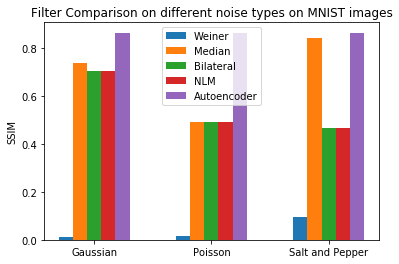

In [78]:
# creating ssim bar plot
labels = ['Gaussian', 'Poisson', 'Salt and Pepper']


x = np.arange(len(labels))  # the label locations
width = 0.12  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/(1/2), ssim_weiner, width, label='Weiner')
rects2 = ax.bar(x - width, ssim_med, width, label='Median')
rects3 = ax.bar(x + 0, ssim_bil, width, label='Bilateral')
rects4 = ax.bar(x + width, ssim_nlm, width, label='NLM')
rects5 = ax.bar(x + width/(1/2), ssim_autoenc_mnist_list, width, label='Autoencoder')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('SSIM')
ax.set_title('Filter Comparison on different noise types on MNIST images')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.savefig('SSIM-vs-noises-perfilter-MNIST.png', bbox='tight',dpi=300)

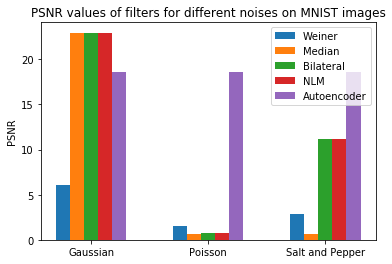

In [79]:
# Creating PSNR plots
labels = ['Gaussian', 'Poisson', 'Salt and Pepper']

fig1, ax1 = plt.subplots()

rects1 = ax1.bar(x - width/(1/2), psnr_weiner, width, label='Weiner')
rects2 = ax1.bar(x - width, psnr_med, width, label='Median')
rects3 = ax1.bar(x + 0, psnr_bil, width, label='Bilateral')
rects4 = ax1.bar(x + width, psnr_nlm, width, label='NLM')
rects5 = ax1.bar(x + width/(1/2), psnr_autoenc_mnist_list, width, label='Autoencoder')


# Add some text for labels, title and custom x-axis tick labels, etc.
ax1.set_ylabel('PSNR')
ax1.set_title('PSNR values of filters for different noises on MNIST images')
ax1.set_xticks(x)
ax1.set_xticklabels(labels)
ax1.legend()
plt.savefig('PSNR-vs-noises-perfilter-MNIST.png', bbox='tight',dpi=300)